### Imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from random import seed
from random import randrange
import seaborn as sns

---
### Upload Dataset

In [2]:
X_und = pd.read_csv("cleaned_rain_x.csv")
y_und = pd.read_csv("cleaned_rain_y.csv")

---
### Split into testing and training data

In [3]:
x_train, x_test, y_train, y_test = train_test_split(X_und, y_und, test_size=0.25, random_state=42)

---
### Create 'Total' Train DataFrame

In [4]:
x_train_total = pd.concat([x_train, y_train], axis=1)
x_train_total.drop(columns=['Unnamed: 0'], axis=1, inplace=True)
x_train_total.head()

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,RainTomorrow
22845,-0.925855,-1.343428,0.213256,0.145445,1.220578,0.274457,0.183993,0.755625,1.500069,0.894962,...,1.088941,-0.929551,-0.843587,-0.839679,1.169532,-0.846416,-0.822150,1.097495,1.094764,0
42446,1.314874,0.856220,0.352357,0.376646,0.437868,0.382385,1.842494,-0.917119,-0.666636,0.499156,...,1.088941,1.075788,1.185414,-0.839679,-0.855043,-0.846416,-0.822150,-0.911166,1.094764,1
5989,0.610645,0.741206,-0.273598,0.376646,0.214237,0.166529,0.137924,-0.533211,-0.666636,0.894962,...,-0.918324,-0.929551,-0.843587,1.190932,1.169532,-0.846416,1.216322,1.097495,-0.913439,0
39347,-0.077579,0.223641,0.491458,-1.126157,-1.462998,0.382385,-0.645257,-0.231568,-0.666636,0.499156,...,-0.918324,-0.929551,-0.843587,1.190932,1.169532,-0.846416,1.216322,1.097495,-0.913439,1
31998,-1.117918,-0.811487,-0.690902,-0.779357,0.214237,1.299772,-0.092423,1.797663,1.500069,-1.479872,...,-0.918324,1.075788,-0.843587,-0.839679,1.169532,-0.846416,1.216322,1.097495,-0.913439,1


---
# Evaluators
---

In [5]:
def conf(TP, FP, TN, FN):
    cf = np.array([[TN, FP], [FN, TP]])
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in
                    cf.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                         cf.flatten()/np.sum(cf)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf, annot=labels, fmt='', 
                cmap=sns.diverging_palette(230, 20, center='light'))

In [6]:
def TF(y_actu, y_pred):
    TP = np.sum(np.logical_and(y_pred == 1, y_actu == 1))
    TN = np.sum(np.logical_and(y_pred == 0, y_actu == 0))
    FP = np.sum(np.logical_and(y_pred == 1, y_actu == 0))
    FN = np.sum(np.logical_and(y_pred == 0, y_actu == 1))
    conf(TP, FP, TN, FN)
    return TP, FP, TN, FN

In [7]:
def eval(models, test_x, test_y):
    for m in models:
        model = m[0]
        TP, FP, TN, FN = TF(test_y, np.array(model.predict(test_x)))
        acc = (TP + TN) / (TP + TN + FP + FN)
        pre = TP / (TP + FP)
        re = TP / (FN + TP)
        f1 = (2 * (pre * re)) / (pre + re)
        scoring = {m[1]:{"Accuracy":acc, "Precision":pre,"Recall":re,"F1":f1}}
    return pd.DataFrame(scoring)

---
# Random Forest Implementation
---

In [24]:
class RandomForest():
    
    ## Helper Functions ##
    
    def subsample(self):
        sample = []
        while len(sample) < self.n_sample:
            index = randrange(self.length)
            sample.append(self.data.iloc[index])
        return sample
    
    def test_split(self, index, value, sample):
        left, right = [], []
        for row in sample:
            if row[index] < value:
                left.append(row)
            else:
                right.append(row)
        return left, right
    
    def gini_index(self, groups, classes):
        n_instances = float(sum([len(group) for group in groups]))
        gini = 0.0
        for group in groups:
            size = float(len(group))
            if size == 0:
                continue
            score = 0.0
            for class_val in classes:
                p = [row[-1] for row in group].count(class_val) / size
                score += p * p
            gini += (1.0 - score) * (size / n_instances)
        return gini
    
    def get_split(self, sample):
        class_vals = [set(row[-1] for row in sample)]
        b_index, b_value, b_score, b_groups = 999, 999, 999, None
        features = []
        while len(features) < self.length:
            index = randrange(len(sample[0])-1)
            if index not in features:
                features.append(index)
        for index in features:
            for row in sample:
                groups = self.test_split(index, row[index], sample)
                gini = self.gini_index(groups, class_vals)
                if gini < b_score:
                    b_index, b_value, b_score, b_groups = index, row[index], gini, groups
        return {'index':b_index, 'value':b_value, 'groups':b_groups}
    
    def to_terminal(self, group):
        outcomes = [row[-1] for row in group]
        return max(set(outcomes), key=outcomes.count)
    
    def split(self, root, depth):
        left, right = root['groups']
        del(root['groups'])

        if not left or not right:
            root['left'] = root['right'] = self.to_terminal(left + right)
            return

        if depth >= self.max_depth:
            root['left'], root['right'] = self.to_terminal(left), self.to_terminal(right)
            return

        if len(left) <= self.min_size:
            root['left'] = self.to_terminal(left)
        else:
            root['left'] = self.get_split(left)
            self.split(root['left'], depth+1)

        if len(right) <= self.min_size:
            root['right'] = self.to_terminal(right)
        else:
            root['right'] = self.get_split(right)
            self.split(root['right'], depth+1)
    
    def build_tree(self, sample):
        root = self.get_split(sample)
        self.split(root, 1)
        return root
    
    def predict_one(self, node, row):
        if row[node['index']] < node['value']:
            if isinstance(node['left'], dict):
                return self.predict_one(node['left'], row)
            else:
                return node['left']
        else:
            if isinstance(node['right'], dict):
                return self.predict_one(node['right'], row)
            else:
                return node['right']
    
    def bagging_predict(self, trees, row):
        predictions = [self.predict_one(tree, row[1]) for tree in trees]
        return max(set(predictions), key=predictions.count)
 
    ######################
    

    def __init__(self, train_data=x_train_total, y="RainTomorrow",
                 max_depth=5, min_size=1, n_trees=5):
        self.data = train_data
        self.length = len(self.data)
        self.cols = list(train_data.columns.values)
        self.y = y
        self.max_depth = max_depth
        self.min_size = min_size
        self.n_trees = n_trees
        self.n_sample = round(self.length * n_trees)
        self.train()
        return

    def train(self):
        self.trees = []
        for i in range(self.n_trees):
            sample = self.subsample()
            tree = self.build_tree(sample)
            self.trees.append(tree)
  
    def predict(self, test=x_test):
        predictions = [self.bagging_predict(self.trees, row) for row in test.iterrows()]
        return predictions

---
# RESULTS
---

,Random Forest (Subset of 20)
Accuracy,0.524504
F1,0.634258
Precision,0.517876
Recall,0.818111


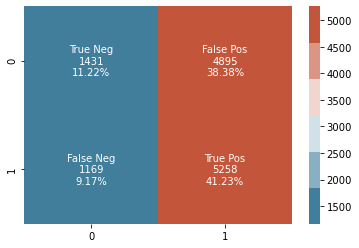

In [25]:
RF = RandomForest(train_data=x_train_total.iloc[120:140])
eval([[RF, "Random Forest (Subset of 20)"]], x_test, y_test['RainTomorrow'])